In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

#### Notes on performing model comparison in pymc3 and arviz

Chapter 7 introduced the topic of model comparison using PSIS and WAIC. McElreath provides these functions in his 'rethinking' package. 

I found functions performing the same in arviz

See:
1. https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html
2. https://arviz-devs.github.io/arviz/api/generated/arviz.plot_compare.html
3. https://arviz-devs.github.io/arviz/api/generated/arviz.from_pymc3.html

To perfrom model comparison, there's a function in arviz 

arviz.compare(compare_dict: {'model name' : inference_data object, ic : 'loo or waic'}

Takes as input a dictionary of model names and what is called an inference data object for that model. 

ic: the information criterion you want to use. Two are provided:

loo: Pareto smoothed importance sampling leave-one-out cross-validation (LOO) or using the widely applicable information criterion (WAIC).

To create an inference data object for your model using pymc3 objects, you can use

arviz.from_pymc3 (trace, prior = prior_predective, posterior_predictive)

And finally, to plot the comparisons, you take the dataframes provided by compare function and use arviz.plot_compare(dataframe)

Interpreting the output of the compre function: (copied from https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html) 

A DataFrame, ordered from best to worst model (measured by the ELPD).
The index reflects the key with which the models are passed to this function. The columns are:

rank: The rank-order of the models. 0 is the best.

elpd: ELPD estimated either using (PSIS-LOO-CV elpd_loo or WAIC elpd_waic).
**Higher ELPD indicates higher out-of-sample predictive fit (“better” model)**. If scale is deviance or negative_log smaller values indicates higher out-of-sample predictive fit (“better” model).


weight: Relative weight for each model.
This can be loosely interpreted as the probability of each model (among the compared model) given the data.

SE: Standard error of the ELPD estimate.

dSE: Standard error of the difference in ELPD between each model and the top-ranked model.
It’s always 0 for the top-ranked model.
warning: A value of 1 indicates that the computation of the ELPD may not be reliable.
This could be indication of WAIC/LOO starting to fail see http://arxiv.org/abs/1507.04544 for details.
scale: Scale used for the ELPD.

1. Revisit the marriage,age,and happiness collider bias example from Chapter 6. Run models m6.9 and m6.10 again (pages 178–179). Compare these two models using both PSIS and WAIC. Which model is expected to make better predictions, according to these criteria? On the basis of the causal model, how should you interpret the parameter estimates from the model preferred by PSIS and WAIC?

In [3]:
# code copied from (https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_06.ipynb) 
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))


def sim_happiness(N_years=100, seed=1234):
    np.random.seed(seed)

    popn = pd.DataFrame(np.zeros((20 * 65, 3)), columns=["age", "happiness", "married"])
    popn.loc[:, "age"] = np.repeat(np.arange(65), 20)
    popn.loc[:, "happiness"] = np.repeat(np.linspace(-2, 2, 20), 65)
    popn.loc[:, "married"] = np.array(popn.loc[:, "married"].values, dtype="bool")

    for i in range(N_years):
        # age population
        popn.loc[:, "age"] += 1
        # replace old folk with new folk
        ind = popn.age == 65
        popn.loc[ind, "age"] = 0
        popn.loc[ind, "married"] = False
        popn.loc[ind, "happiness"] = np.linspace(-2, 2, 20)

        # do the work
        elligible = (popn.married == 0) & (popn.age >= 18)
        marry = np.random.binomial(1, inv_logit(popn.loc[elligible, "happiness"] - 4)) == 1
        popn.loc[elligible, "married"] = marry

    popn.sort_values("age", inplace=True, ignore_index=True)

    return popn

In [4]:
#code copied from same source above
popn = sim_happiness()

popn_summ = popn.copy()
popn_summ["married"] = popn_summ["married"].astype(
    int
)  # this is necessary before using az.summary, which doesn't work with boolean columns.
az.summary(popn_summ.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
age,32.00,18.77,0.0,61.00
happiness,-0.00,1.21,-2.0,1.79
married,0.28,0.45,0.0,1.00


In [5]:
popn.age.min(), popn.age.max()

(0, 64)

In [6]:
#models conside adults only
adults = popn[popn.age>=18]

In [7]:
# Age is rescaled as Age = (Age - 18) / (65-18)

In [8]:
adults['age_s'] = (adults.age - 18) / (65-18)

/var/folders/9p/5ycxgmps44zc3f0y6vljhp2h0000gn/T/ipykernel_31699/787848563.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adults['age_s'] = (adults.age - 18) / (65-18)


model m_6_9 takes into account marriag status

$\mu_i = \alpha_{MID[i]} + \beta_A A_i$

In [9]:
# extract values for categorical variable
mid = pd.Categorical(adults.loc[:,'married'].astype(int))

In [10]:
# marital status taken into account
with pm.Model() as m69:
    a = pm.Normal('a',mu =0, sd = 1, shape = 2)
    bA = pm.Normal('bA', mu = 0, sd = 2)
    
    mu = a[mid] + bA*adults.age_s
    
    sigma = pm.Exponential('sigma', 1)
    
    happiness = pm.Normal('happiness', mu = mu, sd = sigma, observed = adults.happiness)
    trace_m69 = pm.sample(1000, tune = 1000)
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace_m69)
    inference_data_m69 = az.from_pymc3(trace = trace_m69,
                                       prior = prior,
                                       posterior_predictive = posterior_predictive)

/var/folders/9p/5ycxgmps44zc3f0y6vljhp2h0000gn/T/ipykernel_31699/428494606.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_m69 = pm.sample(1000, tune = 1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]


/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [11]:
az.summary(trace_m69)

/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.202,0.069,-0.338,-0.076,0.002,0.001,1803.0,1672.0,1.0
a[1],1.212,0.095,1.035,1.389,0.002,0.002,1824.0,1906.0,1.0
bA,-0.713,0.127,-0.947,-0.473,0.003,0.002,1654.0,1645.0,1.0
sigma,1.022,0.023,0.978,1.063,0.000,0.000,2374.0,2339.0,1.0


Model m.6.10 doesn't take marital status into account

In [12]:
with pm.Model() as m610:
    a = pm.Normal('a', mu = 0, sd = 1)
    bA = pm.Normal('bA', mu = 0, sd = 2)
    
    mu = a + bA*adults.age_s
    sigma = pm.Exponential('sigma',1)
    happiness = pm.Normal('happiness', mu = mu, sd = sigma, observed = adults.happiness)
    trace_m610 = pm.sample(1000, tune = 1000)
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace_m610)
    inference_data_m610 = az.from_pymc3(trace = trace_m610,
                                       prior = prior,
                                       posterior_predictive = posterior_predictive)

/var/folders/9p/5ycxgmps44zc3f0y6vljhp2h0000gn/T/ipykernel_31699/2351941922.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_m610 = pm.sample(1000, tune = 1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]


/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [13]:
az.summary(trace_m610)

/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.002,0.078,-0.150,0.142,0.002,0.001,2115.0,1868.0,1.0
bA,-0.003,0.135,-0.265,0.236,0.003,0.002,2073.0,2180.0,1.0
sigma,1.215,0.028,1.166,1.268,0.001,0.000,2610.0,2333.0,1.0


In [14]:
# Model comparison
compare_dict = {'m69':inference_data_m69, 'm610':inference_data_m610}

In [15]:
compare_df_psis = az.compare(compare_dict, ic = 'loo')

/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])


In [16]:
compare_df_waic = az.compare(compare_dict, ic = 'waic')

/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])


In [17]:
compare_df_psis

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m69,0,-1355.568039,3.738507,0.000000,0.979098,18.648068,0.000000,False,log
m610,1,-1518.683178,2.336600,163.115138,0.020902,13.690499,16.520226,False,log


In [18]:
compare_df_waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m69,0,-1355.568172,3.738640,0.000000,0.979097,18.648082,0.000000,False,log
m610,1,-1518.683166,2.336589,163.114995,0.020903,13.690498,16.520239,False,log


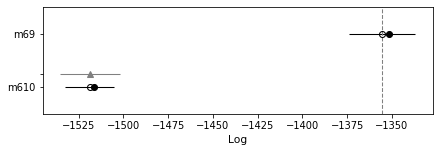

In [19]:
az.plot_compare(compare_df_psis);

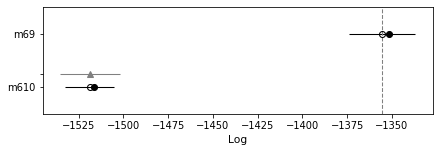

In [20]:
az.plot_compare(compare_df_waic);

Interpretation: The generated data comes from the model $H \rightarrow M \leftarrow A$ ie: Happiness and Age cause Marriage (a collider), but Age doesNOT cause happiness.

We have two models above: m69 which thinks that marriage can actually cause happiness and m610 which is the correct model (marriage does not cause happiness). Both PSIS and WAIC give the wrong model (m69) higher scores and rank, that it will perform better in predicting whethere someone will be happy or not. So why does including marriage (non-causal) improve prediction? Because, while non-causal, it's still extra information and the more you know, the better you predict.

How do we interpret parameter estimates in models based on PSIS and WAIC?

For the confouded model:

bA: the conditional association of happiness and age given martial status

a1,a2: association of marriae and happiness BIASED by age

2. Reconsider the urban fox analysis from last week’s homework. On the basis of PSIS and WAIC scores, which combination of variables best predicts body weight (W, weight)? How would you interpret the estimates from the best scoring model?

In [21]:
path = '/Users/amralaa/CS - AGI core/[Prereq] Statistical Rethinking/resources/Rethinking_2/End_of_chapter_problems/data/foxes.csv'

In [22]:
foxes = pd.read_csv(path, delimiter = ';')

In [23]:
foxes.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


In [24]:
def standardize(series):
    '''
    To standardize panads series and return the standardized series object
    '''
    return (series - series.mean()) / series.std()

In [25]:
foxes.avgfood = standardize(foxes.avgfood)
foxes.area = standardize(foxes.area)
foxes.weight = standardize(foxes.weight)
foxes.groupsize = standardize(foxes.groupsize)

In [26]:
foxes.head()

,group,avgfood,groupsize,area,weight
0,1,-1.924829,-1.524089,-2.239596,0.414135
1,1,-1.924829,-1.524089,-2.239596,-1.427046
2,2,-1.118035,-1.524089,-1.205508,0.675954
3,2,-1.118035,-1.524089,-1.205508,1.300942
4,3,-1.319734,-1.524089,-1.130106,1.115135


In [27]:
# we can build 7 models representing all possible 7 models

#area only model W = f(A)
with pm.Model() as mA:
    sigma = pm.Exponential('sigma',1)
    a = pm.Normal('a', mu = 0, sd = 0.2)
    bA = pm.Normal('bA', mu = 0, sd = 0.5)
    mu = a + bA*foxes.area
    weight = pm.Normal('weight', mu = mu, sd = sigma, observed = foxes.weight)
    trace_A = pm.sample()
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace_A)
    inference_data_mA = az.from_pymc3(trace = trace_A, 
                                     prior = prior,
                                     posterior_predictive = posterior_predictive)

/var/folders/9p/5ycxgmps44zc3f0y6vljhp2h0000gn/T/ipykernel_31699/2412241675.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_A = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bA, a, sigma]


/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [28]:
#food only model W = f(F)
with pm.Model() as mF:
    sigma = pm.Exponential('sigma',1)
    a = pm.Normal('a', mu = 0, sd = 0.2)
    bF = pm.Normal('bF', mu = 0, sd = 0.5)
    mu = a + bF*foxes.avgfood
    weight = pm.Normal('weight', mu = mu, sd = sigma, observed = foxes.weight)
    trace_F = pm.sample()
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace_F)
    inference_data_mF = az.from_pymc3(trace = trace_F, 
                                     prior = prior,
                                     posterior_predictive = posterior_predictive)

/var/folders/9p/5ycxgmps44zc3f0y6vljhp2h0000gn/T/ipykernel_31699/1078096553.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_F = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bF, a, sigma]


/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [29]:
#groupsize only model W = f(G)
with pm.Model() as mG:
    sigma = pm.Exponential('sigma',1)
    a = pm.Normal('a', mu = 0, sd = 0.2)
    bG = pm.Normal('bG', mu = 0, sd = 0.5)
    mu = a + bG*foxes.groupsize
    weight = pm.Normal('weight', mu = mu, sd = sigma, observed = foxes.weight)
    trace_G = pm.sample()
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace_G)
    inference_data_mG = az.from_pymc3(trace = trace_G, 
                                     prior = prior,
                                     posterior_predictive = posterior_predictive)

/var/folders/9p/5ycxgmps44zc3f0y6vljhp2h0000gn/T/ipykernel_31699/1148671607.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_G = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bG, a, sigma]


/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [30]:
#Area and Food  model W = f(A,F)
with pm.Model() as mAF:
    sigma = pm.Exponential('sigma',1)
    a = pm.Normal('a', mu = 0, sd = 0.2)
    bA = pm.Normal('bA', mu = 0, sd = 0.5)
    bF = pm.Normal('bF', mu = 0, sd = 0.5)
    mu = a + bA*foxes.area + bF*foxes.avgfood
    weight = pm.Normal('weight', mu = mu, sd = sigma, observed = foxes.weight)
    trace_AF = pm.sample()
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace_AF)
    inference_data_mAF = az.from_pymc3(trace = trace_AF, 
                                     prior = prior,
                                     posterior_predictive = posterior_predictive)

/var/folders/9p/5ycxgmps44zc3f0y6vljhp2h0000gn/T/ipykernel_31699/429245167.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_AF = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bF, bA, a, sigma]


/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.892007929543205, but shoul

In [31]:
#Area and Groupsize  model W = f(A,G)
with pm.Model() as mAG:
    sigma = pm.Exponential('sigma',1)
    a = pm.Normal('a', mu = 0, sd = 0.2)
    bA = pm.Normal('bA', mu = 0, sd = 0.5)
    bG = pm.Normal('bG', mu = 0, sd = 0.5)
    mu = a + bA*foxes.area + bG*foxes.groupsize
    weight = pm.Normal('weight', mu = mu, sd = sigma, observed = foxes.weight)
    trace_AG = pm.sample()
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace_AG)
    inference_data_mAG = az.from_pymc3(trace = trace_AG, 
                                     prior = prior,
                                     posterior_predictive = posterior_predictive)

/var/folders/9p/5ycxgmps44zc3f0y6vljhp2h0000gn/T/ipykernel_31699/2942931898.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_AG = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bG, bA, a, sigma]


/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


In [32]:
#Food and Groupsize  model W = f(F,G)
with pm.Model() as mFG:
    sigma = pm.Exponential('sigma',1)
    a = pm.Normal('a', mu = 0, sd = 0.2)
    bF = pm.Normal('bF', mu = 0, sd = 0.5)
    bG = pm.Normal('bG', mu = 0, sd = 0.5)
    mu = a + bF*foxes.avgfood + bG*foxes.groupsize
    weight = pm.Normal('weight', mu = mu, sd = sigma, observed = foxes.weight)
    trace_FG = pm.sample()
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace_FG)
    inference_data_mFG = az.from_pymc3(trace = trace_FG, 
                                     prior = prior,
                                     posterior_predictive = posterior_predictive)

/var/folders/9p/5ycxgmps44zc3f0y6vljhp2h0000gn/T/ipykernel_31699/4194489060.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_FG = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bG, bF, a, sigma]


/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


In [33]:
# all variables model
with pm.Model() as mAFG:
    sigma = pm.Exponential('sigma',1)
    a = pm.Normal('a', mu = 0, sd = 0.2)
    bA = pm.Normal('bA', mu = 0, sd = 0.5)
    bF = pm.Normal('bF', mu = 0, sd = 0.5)
    bG = pm.Normal('bG', mu = 0, sd = 0.5)
    mu = a + bA*foxes.area + bG*foxes.groupsize + bF*foxes.avgfood
    weight = pm.Normal('weight', mu = mu, sd = sigma, observed = foxes.weight)
    trace_AFG = pm.sample()
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace_AFG)
    inference_data_mAFG = az.from_pymc3(trace = trace_AFG, 
                                     prior = prior,
                                     posterior_predictive = posterior_predictive)

/var/folders/9p/5ycxgmps44zc3f0y6vljhp2h0000gn/T/ipykernel_31699/3217305360.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_AFG = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bG, bF, bA, a, sigma]


/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [34]:
compare_dict_foxes = {'mA': inference_data_mA,
                   'mF' : inference_data_mF,
                   'mG' : inference_data_mG,
                   'mAG': inference_data_mAG,
                   'mAF' : inference_data_mAF,
                   'mFG' : inference_data_mFG,
                   'mAFG' : inference_data_mAFG}

In [35]:
az.compare(compare_dict_foxes, ic = 'waic')

/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:212: FutureWarning: The frame.append method is depr

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
mAFG,0,-161.572030,4.604878,0.000000,0.000000,7.741545,0.000000,True,log
mFG,1,-161.765645,3.405734,0.193615,0.524179,7.648804,1.671314,False,log
mAG,2,-161.879700,3.546500,0.307670,0.475821,7.529432,1.366099,True,log
mG,3,-165.378565,2.586734,3.806535,0.000000,7.053853,2.791455,False,log
mF,4,-166.696831,2.324193,5.124801,0.000000,6.638175,3.363065,False,log
mA,5,-166.831357,2.547566,5.259327,0.000000,6.649867,3.389021,False,log
mAF,6,-167.185226,3.365713,5.613196,0.000000,6.739894,3.271009,False,log


In [36]:
df_psis = az.compare(compare_dict_foxes, ic='loo')

/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:212: FutureWarning: The frame.append method is depr

In [37]:
df_psis

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
mAFG,0,-161.577796,4.610645,0.000000,1.020328e-15,7.742809,0.000000,False,log
mFG,1,-161.774578,3.414667,0.196782,5.239262e-01,7.651086,1.672071,False,log
mAG,2,-161.887299,3.554099,0.309503,4.760738e-01,7.530778,1.365347,False,log
mG,3,-165.382344,2.590513,3.804548,0.000000e+00,7.054847,2.793020,False,log
mF,4,-166.697153,2.324515,5.119357,2.144511e-16,6.638004,3.364983,False,log
mA,5,-166.834899,2.551108,5.257103,6.015339e-16,6.650691,3.390883,False,log
mAF,6,-167.191074,3.371561,5.613278,0.000000e+00,6.740992,3.272351,False,log


The DAG on which this is based looks like

<div>
    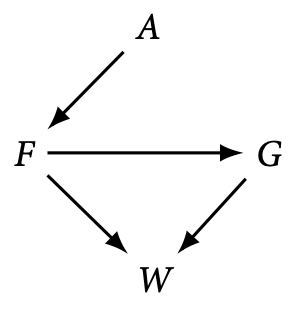
</div>

So, it looks like the model with all 3 variables is the best, but not much better than models with 2 predictors Area&Groupsize or Food&Groupsize and same for one predictor Groupsize.

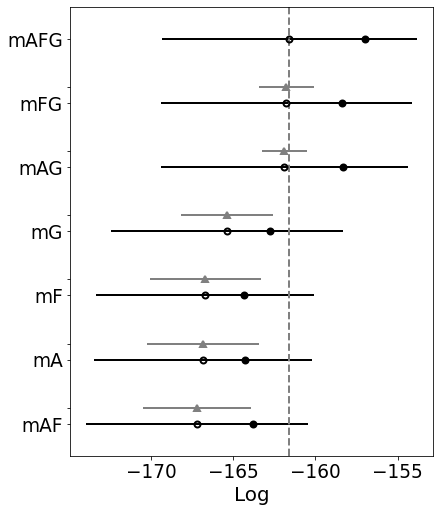

In [38]:
az.plot_compare(df_psis);

In [39]:
az.summary(trace_AFG)

/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.083,-0.165,0.149,0.001,0.001,3468.0,2439.0,1.0
bA,0.274,0.175,-0.054,0.601,0.003,0.002,3277.0,2600.0,1.0
bF,0.291,0.225,-0.133,0.705,0.005,0.003,2106.0,2477.0,1.0
bG,-0.631,0.195,-1.005,-0.265,0.004,0.003,2434.0,2317.0,1.0
sigma,0.955,0.066,0.829,1.074,0.001,0.001,3031.0,2484.0,1.0


How to interpret these parameters? DAG analysis:

1. bG

G -> W

G <- F -> W (non-causal path)

since F is included, then non-causal path is blocked. So bG measures direct causal effect of G on W ie G -> W

2. bF

F -> W

F -> G -> W (indirect path) 

So bF should be measuring direct causal effect of F -> G. But because we also included A in the model, this reduces variability in bF and makes it a less accurate measure than if we didn't include A

3. bA

doesn't measure anything since path from A -> F -> W is blocked by conditioning on F

So, why is bA (in the 3 variable model) associated with W? is there an unkown path connecting the two? is it a fluke of the sample?

3. Build a predictive model of the relationship shown on the cover of the book, the relationship between the timing of cherry blossoms and March temperature in the same year. The data are found in data(cherry_blossoms). Consider at least two functions to predict doy with temp. Compare them with PSIS or WAIC.

    Suppose March temperatures reach 9 degrees by the year 2050. What does your best model predict for the predictive distribution of the day-in-year that the cherry trees will blossom?

In [40]:
path2 = '/Users/amralaa/CS - AGI core/[Prereq] Statistical Rethinking/resources/Rethinking_2/End_of_chapter_problems/data/cherry_blossoms.csv'

In [41]:
blossom = pd.read_csv(path2, delimiter = ';')

In [42]:
blossom.head()

,year,doy,temp,temp_upper,temp_lower
0,801,NaN,NaN,NaN,NaN
1,802,NaN,NaN,NaN,NaN
2,803,NaN,NaN,NaN,NaN
3,804,NaN,NaN,NaN,NaN
4,805,NaN,NaN,NaN,NaN


In [43]:
blossom = blossom.dropna()

In [44]:
blossom.head()

,year,doy,temp,temp_upper,temp_lower
50,851,108.0,7.38,12.10,2.66
63,864,100.0,6.42,8.69,4.14
65,866,106.0,6.44,8.11,4.77
88,889,104.0,6.83,8.48,5.19
90,891,109.0,6.98,8.96,5.00


In [45]:
temp_mean = blossom.temp.mean()
temp_std = blossom.temp.std()

In [46]:
# standardize data
blossom.doy = standardize(blossom.doy)
blossom.temp = standardize(blossom.temp)

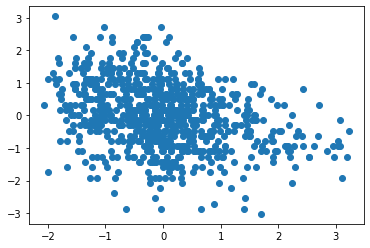

In [47]:
plt.scatter(blossom.temp, blossom.doy);

We'll consider a linear model and a quadratic model.

In [48]:
from theano import shared

In [49]:
temp_shared = shared(blossom.temp.values)

In [50]:
with pm.Model() as intercept:
    a = pm.Normal('a', mu = 0, sd = 0.2)
    sigma = pm.Exponential('sigma', 1)
    mu = a
    doy = pm.Normal('doy', mu = mu, sd = sigma, observed = blossom.doy)
    
    trace_intercept = pm.sample()
    prior_predictive = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace_intercept)
    
    inference_data_intercept = az.from_pymc3(trace = trace_intercept,
                                         prior = prior_predictive,
                                         posterior_predictive = posterior_predictive)

/var/folders/9p/5ycxgmps44zc3f0y6vljhp2h0000gn/T/ipykernel_31699/1874581102.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_intercept = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a]


/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [51]:
with pm.Model() as linear:
    a = pm.Normal('a', mu = 0, sd = 0.2)
    bT = pm.Normal('bT', mu = 0, sd = 0.5)
    sigma = pm.Exponential('sigma', 1)
    
    mu = a + bT * temp_shared
    doy = pm.Normal('doy', mu = mu, sd = sigma, observed = blossom.doy)
    
    trace_linear = pm.sample()
    prior_predictive = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace_linear)
    
    inference_data_linear = az.from_pymc3(trace = trace_linear,
                                         prior = prior_predictive,
                                         posterior_predictive = posterior_predictive)

/var/folders/9p/5ycxgmps44zc3f0y6vljhp2h0000gn/T/ipykernel_31699/2172050093.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_linear = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bT, a]


/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


In [52]:
with pm.Model() as quadratic:
    a = pm.Normal('a', mu = 0, sd = 0.2)
    bT1 = pm.Normal('bT', mu = 0, sd = 0.5)
    bT2 = pm.Normal('bT2', mu = 0, sd = 0.5)
    sigma = pm.Exponential('sigma', 1)
    
    mu = a + bT1 * temp_shared + bT2 * (temp_shared**2)
    doy = pm.Normal('doy', mu = mu, sd = sigma, observed = blossom.doy)
    
    trace_quadratic = pm.sample()
    prior_predictive = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace_quadratic)
    
    inference_data_quadratic = az.from_pymc3(trace = trace_quadratic,
                                         prior = prior_predictive,
                                         posterior_predictive = posterior_predictive)

/var/folders/9p/5ycxgmps44zc3f0y6vljhp2h0000gn/T/ipykernel_31699/3289123066.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_quadratic = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bT2, bT, a]


/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [53]:
az.summary(trace_linear)

/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.000,0.034,-0.064,0.063,0.0,0.001,4849.0,2891.0,1.0
bT,-0.326,0.034,-0.388,-0.263,0.0,0.000,5334.0,2847.0,1.0
sigma,0.947,0.024,0.904,0.994,0.0,0.000,4805.0,3046.0,1.0


In [54]:
az.summary(trace_quadratic)

/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.040,-0.080,0.072,0.001,0.001,2898.0,3169.0,1.0
bT,-0.326,0.036,-0.391,-0.256,0.001,0.000,3800.0,2988.0,1.0
bT2,0.001,0.024,-0.043,0.046,0.000,0.000,2575.0,2687.0,1.0
sigma,0.947,0.024,0.904,0.994,0.000,0.000,4805.0,3209.0,1.0


In [55]:
compare_dict_blossom = {'intercept': inference_data_intercept,
                       'linear' : inference_data_linear,
                       'quadratic' : inference_data_quadratic}

In [56]:
az.compare(compare_dict_blossom)

/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
/Users/amralaa/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:212: FutureWarning: The frame.append method is depr

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
linear,0,-1074.648784,2.855230,0.000000,1.000000e+00,20.319051,0.000000,False,log
quadratic,1,-1075.538617,3.608738,0.889833,3.275158e-15,20.319018,0.096725,False,log
intercept,2,-1118.228625,2.011518,43.579840,0.000000e+00,19.741513,8.335946,False,log


The linear model appears to be only slightly better than the quadratic and both much better than the intercept only model.

Now for the second part of the problem: Suppose March temperatures reach 9 degrees by the year 2050. What does your best model predict for the predictive distribution of the day-in-year that the cherry trees will blossom?

In [57]:
blossom.shape

(787, 5)

In [62]:
#standardized temperature sequence
temp_seq = (np.linspace(0,9,blossom.shape[0]) - temp_mean)/temp_std

In [65]:
temp_shared.set_value(temp_seq)
with linear:
    #counterfactual samples
    year50_samples = pm.sample_posterior_predictive(trace_linear)

In [78]:
blossom_original = pd.read_csv(path2, delimiter = ';').dropna()

In [80]:
doy_mean = blossom_original.doy.mean()
doy_std = blossom_original.doy.std()

In [81]:
# remember, we had standardized all values so we need to get the original back
year50_post = (year50_samples['doy'][:,-1] * doy_std) + doy_mean

In [82]:
year50_post

array([ 95.22674265,  95.13186815,  91.79459575, ..., 101.23573588,
        93.09799648,  86.87724345])

In [ ]:
year

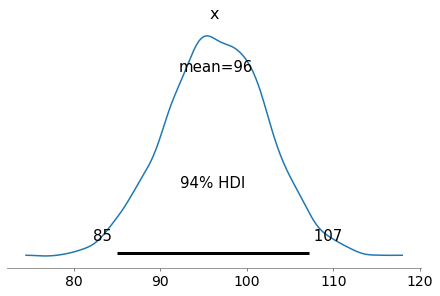

In [85]:
az.plot_posterior(year50_post);

4-OPTIONALCHALLENGE. The data in data(Dinosaurs) are body mass estimates at different estimated ages for six different dinosaur species. See ?Dinosaurs for more details. Choose one or more of these species (at least one, but as many as you like) and model its growth. To be precise: Make a predictive model of body mass using age as a predictor. Consider two or more model types for the function relating age to body mass and score each using PSIS and WAIC.
Which model do you think is best, on predictive grounds? On scientific grounds? If your answers to these questions differ, why?
This is a challenging exercise, because the data are so scarce. But it is also a realistic example, because people publish Nature papers with even less data. So do your best, and I look forward to seeing your growth curves.